In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader
from tqdm import tqdm 

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")


def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')
    
    


Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/home/linuxbrew/.linuxbrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Using GPU!


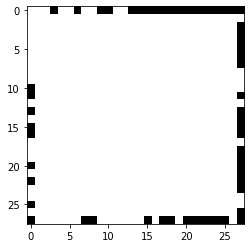

In [141]:
# Generating the dataset 
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


p = 0.7
q = 0.3

std = torch.ones(1,28,28)/2

patternLeft = torch.zeros((1,28,28))
patternLeft[0,:,:14] = p 
patternLeft[0,:,14:] = q
patternRight = torch.flip(patternLeft,[2])

# Adversarial space
std[0,1:-1,1:-1]=0
patternRight[0,1:-1,1:-1]=1
patternLeft[0,1:-1,1:-1]=1


batch_size = 32 
n_batch = 100 
X = torch.zeros(batch_size*n_batch,1,28,28)
label = torch.zeros(batch_size*n_batch,dtype=int)
for idx in range(batch_size*n_batch):
    side = int(torch.bernoulli(torch.tensor([0.5])).item())
    label[idx] = side
    if side > 0.5:
        X[idx]=torch.bernoulli(patternRight)
    else:
        X[idx]=torch.bernoulli(patternLeft)
        
print28x28tensor(X[4])

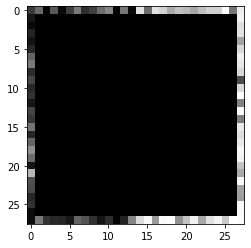

In [155]:
# Generating the continuous dataset 
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


mask = torch.ones(1,28,28)
mask[0,1:-1,1:-1]= 0
left = False*torch.zeros((1,28,28),dtype=bool)
left[0,:,:14]=True

squeeze = 4

batch_size = 32 
n_batch = 100 
X = torch.zeros(batch_size*n_batch,1,28,28)
label = torch.zeros(batch_size*n_batch,dtype=int)
for idx in range(batch_size*n_batch):
    side = int(torch.bernoulli(torch.tensor([0.5])).item())
    label[idx] = side
    if side > 0.5:
        sideMask = left 
        
    else:
        sideMask= torch.logical_not(left)
        
    X[idx]=torch.rand((1,28,28))*mask
    
    X[idx][sideMask]=(X[idx][sideMask])**(1/squeeze)
    nsideMask = torch.logical_not(sideMask)
    X[idx][nsideMask]=1-(1-X[idx][nsideMask])**(1/squeeze)
print28x28tensor(X[4])

In [156]:

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 
import os 


def mode_transform_save(weights,name,nodeColor='blue',sigmaThreshold=3):
    S = []
    V = []
    U = []
    K = []
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(V)-1)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E2=torch.abs(adjacency[k])
        for i in range(E2.shape[0]):
            for j in range(E2.shape[1]):
                Emin = sigmaThreshold*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":1},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)




    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        mode='markers',
        showlegend=False,
        marker=go.scatter.Marker(
            opacity=1,
            color = nodeColor
        ))

    fig.add_trace(node_trace)

    #fig.show()
    fig.write_image("record/"+name+'.png')
    return U,S,V


def mode_transform(weights,sigmaThreshold=3):
    S = []
    V = []
    U = []
    K = []
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(arch)-2)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E2=torch.abs(adjacency[k])
        for i in range(E2.shape[0]):
            for j in range(E2.shape[1]):
                Emin = sigmaThreshold*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":1},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)




    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        mode='markers',
        showlegend=False,
        marker=go.scatter.Marker(
            opacity=1,
        ))

    fig.add_trace(node_trace)

    fig.show()
    return U,S,V


In [362]:
#from gdeep.data import DataLoaderFromArray -> Useless 


from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()

def H(x):
    y = torch.abs(x)
    return -(y*torch.log(y)).sum()

def train_record_new_model(model,X,y,folder,epochs=5,epochs_adv=[]):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=32


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    #model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
    if not os.path.exists('record/'+folder):
        os.mkdir('record/'+folder)
        
        
    n_batch = len(X_train)//batch_size
    print("Number of batch per epoch : ",n_batch)
    L1 = torch.zeros((n_batch*epochs,len(arch)-2))
    Entropy = torch.zeros((n_batch*epochs,len(arch)-2))
    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(n_batch)):
            if X_train.shape[0]==784:
                data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            else: 
                data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            weights = [A.detach() for A in list(model.parameters())]
            name = folder+'/'+str(epoch)+'_'+str(batch_idx)
            
            if epoch in epochs_adv:
                U,S,V = mode_transform_save(weights,name,nodeColor='red')
                fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]
            else:
                U,S,V = mode_transform_save(weights,name)
            
            
            L1[epoch*n_batch+batch_idx]= torch.tensor([(V[i+1].T@U[i]).norm(1) for i in range(len(V)-1)])
            Entropy[epoch*n_batch+batch_idx]= torch.tensor([H(V[i+1].T@U[i]) for i in range(len(V)-1)])
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = loss_fn(output, target)
            
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            if X_val.shape[1]==784:
                data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            else: 
                data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model,L1,Entropy 

In [158]:
# Training the model 
arch = [28*28,50,50,50,2]
m = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
m,L1,Entropy= train_record_new_model(m,X,label,'LR1',epochs=1,epochs_adv=[])

weights_m = [A.detach().to('cpu') for A in m.parameters()]

Number of batch per epoch :  70


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.03it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  94.19642857142857  %
Test Accuracy :  100.0  %


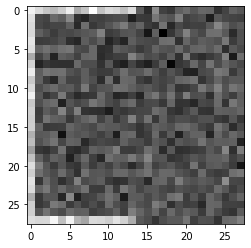

In [171]:
#Attacking 
from foolbox.attacks import L2CarliniWagnerAttack


u,s,v = torch.svd(weights_m[0])
fmodel = PyTorchModel(m, bounds=(0, 1), preprocessing=None)

atkFGM = L2FastGradientAttack()
atk = L2CarliniWagnerAttack()
epsilons=[3.0]
    
data = X
target = label
_,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
data_att=clipped_atk[0]
print28x28tensor(v[:,0])


In [409]:
#Visualisation of attacks 
idx = 1
print28x28tensor(1-data[idx])
plt.show()
print28x28tensor(1-data_att[idx])


RuntimeError: shape '[28, 28]' is invalid for input of size 2

In [173]:
def test(model,X,y):
    output = model(X.to(DEVICE))
    pred=output.argmax(dim=1).to('cpu')
    return ((pred==y).sum()/X.shape[0]*100).item()

print('Accuracy normale :', test(m,data,label))
print('Accuracy Attack  : ', test(m,data_att,label))

Accuracy normale : 100.0
Accuracy Attack  :  80.28125


# Non linear problem

tensor(0)


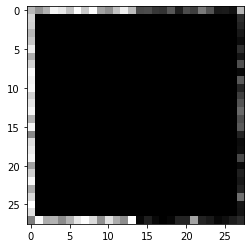

In [253]:
# Generating the continuous dataset 
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


mask = torch.ones(1,28,28)
mask[0,1:-1,1:-1]= 0
left = False*torch.zeros((1,28,28),dtype=bool)
left[0,:,:14]=True

squeeze = 4

batch_size = 32 
n_batch = 400 
X = torch.zeros(batch_size*n_batch,1,28,28)
label = torch.zeros(batch_size*n_batch,dtype=int)
for idx in range(batch_size*n_batch):
    side = 4*torch.rand(1).item()
    label[idx] = side//2
    # 4* side : [0,2] : XOR = 1, [2,4], XOR  = 0 
    if side >= 2:
        sideMask = left + torch.logical_not(left)
        if side>=3:
            sideMask = torch.logical_not(sideMask)
        
    else:
        sideMask=left 
        if side >=1:
            sideMask= torch.logical_not(sideMask)
        
    X[idx]=torch.rand((1,28,28))*mask
    
    X[idx][sideMask]=(X[idx][sideMask])**(1/squeeze)
    nsideMask = torch.logical_not(sideMask)
    X[idx][nsideMask]=1-(1-X[idx][nsideMask])**(1/squeeze)
    
print28x28tensor(X[4])
print(label[4])

In [254]:
# Training the model 
arch = [28*28,50,50,50,2]
m = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
m,L1,Entropy= train_record_new_model(m,X,label,'LR2_nonLinear',epochs=1,epochs_adv=[])

weights_m = [A.detach().to('cpu') for A in m.parameters()]

Number of batch per epoch :  370


100%|█████████████████████████████████████████| 370/370 [01:19<00:00,  4.68it/s]

---------------  Epoch :  0  ---------------
Train Accuracy :  95.48986486486486  %
Test Accuracy :  100.0  %


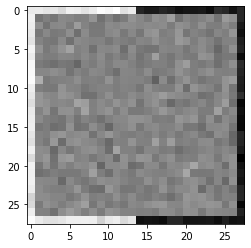

In [337]:
#Attacking 
from foolbox.attacks import L2CarliniWagnerAttack


u,s,v = torch.svd(weights_m[0])
fmodel = PyTorchModel(m, bounds=(0, 1), preprocessing=None)

atkFGM = L2FastGradientAttack()
atk = L2CarliniWagnerAttack()
epsilons=[2.0]
    
data = X
target = label
_,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
data_att=clipped_atk[0]
print28x28tensor(v[:,0])


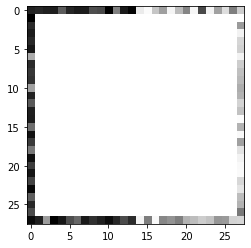

Label :  0


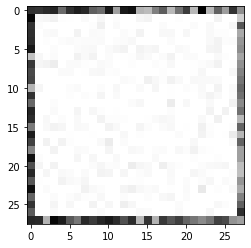

In [272]:
#Visualisation of attacks 
idx = 0
print28x28tensor(1-data[idx])
plt.show()
print28x28tensor(1-data_att[idx])
print('Label : ',label[idx].item())

In [346]:
# Testing 

print('Accuracy normale :', test(m,data,label))
print('Accuracy Attack  : ', test(m,data_att,label))
data_att_cadre= data_att.clone()
data_att_cadre[:,0,1:-1,1:-1]=0
print('Accuracy removing noise from white canvas',test(m,data_att_cadre,label) )

#Projection on 2 most prominent features : 
u,s,v = torch.svd(weights_m[0])
coeffData = torch.einsum('naxy,axyk->nk',data,v[:,:2].reshape(1,28,28,2))
projData = torch.einsum('axyk,nk->naxy',v[:,:2].reshape(1,28,28,2),coeffData)
print('Accuracy normal (proj 2D feature)', test(m,projData,label))
coeffDataAtt = torch.einsum('naxy,axyk->nk',data_att.to('cpu'),v[:,:2].reshape(1,28,28,2))
projDataAtt = torch.einsum('axyk,nk->naxy',v[:,:2].reshape(1,28,28,2),coeffDataAtt)
print('Accuracy attack (proj 2D feature)', test(m,projDataAtt,label))



def succesful_preds(model,X,y):
    output = model(X.to(DEVICE))
    pred=output.argmax(dim=1).to('cpu')
    return (pred==y)


Accuracy normale : 100.0
Accuracy Attack  :  27.9296875
Accuracy removing noise from white canvas 30.109375
Accuracy normal (proj 2D feature) 100.0
Accuracy attack (proj 2D feature) 28.187501907348633


Déduction : 
Ce n'est pas une histoire de dimensionalité, deux dimensions suffisent pour avoir des attaques adversariales 

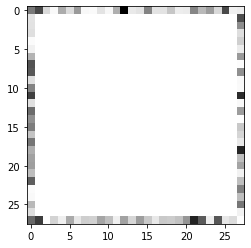

Label :  1


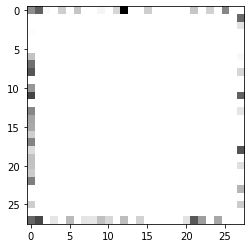

In [336]:
#Visualisation of unsuccesful attacks 
idx = 12

succs = succesful_preds(m,data_att,label)
#succs = torch.logical_not(succs)

print28x28tensor(1-data[succs][idx])
plt.show()
print28x28tensor(1-data_att[succs][idx])
print('Label : ',label[idx].item())

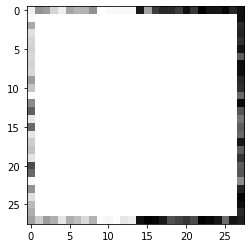

Label :  0


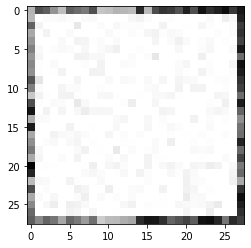

In [281]:
#Visualisation of succesful attacks 
idx = 4

succs = succesful_preds(m,data_att,label)
succs = torch.logical_not(succs)

print28x28tensor(1-data[succs][idx])
plt.show()
print28x28tensor(1-data_att[succs][idx])
print('Label : ',label[idx].item())

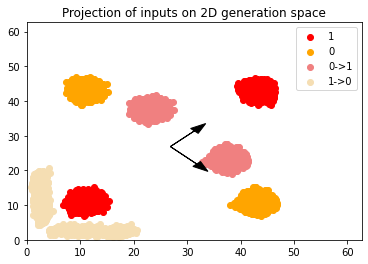

In [321]:
masks = torch.zeros((2,1,28,28))
masks[0][0,:,:14]=1
masks[1][0,:,14:]=1
for i in range(2):
    masks[i][0,1:-1,1:-1]=0
    

X_reduced = torch.einsum('naxy,kaxy->nk',data,masks)
X_att_reduced = torch.einsum('naxy,kaxy->nk',data_att.to('cpu'),masks)

plt.scatter(X_reduced[label==1][:,0],X_reduced[label==1][:,1],color='red',label='1')
plt.scatter(X_reduced[label==0][:,0],X_reduced[label==0][:,1],color='orange',label='0')


succs = torch.logical_not(succesful_preds(m,data_att,label))
X0to1 = X_att_reduced[succs*(label==0)]
X1to0 = X_att_reduced[succs*(label==1)]
plt.scatter(X0to1[:,0],X0to1[:,1],label='0->1',color='lightcoral')
plt.scatter(X1to0[:,0],X1to0[:,1],label='1->0',color='wheat')

plt.legend()
plt.title('Projection of inputs on 2D generation space')
plt.xlim(0,4/3*X_reduced.max())
plt.ylim(0,4/3*X_reduced.max())

u,s,v = torch.svd(weights_m[0])
vecs = (masks.reshape(2,784))@v[:,:2]
center = (X_reduced.min()+X_reduced.max())/2
plt.arrow(center,center,vecs[0,0],vecs[1,0],head_width=2,color='black')
plt.arrow(center,center,vecs[0,1],vecs[1,1],head_width=2,color='black')
plt.show()

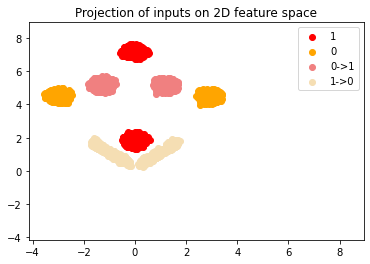

In [325]:
u,s,v = torch.svd(weights_m[0])
v2 = v[:,:2].reshape(1,28,28,2)
                  
X_reduced = torch.einsum('naxy,axyk->nk',data,v2)
X_att_reduced = torch.einsum('naxy,axyk->nk',data_att.to('cpu'),v2)

plt.scatter(X_reduced[label==1][:,0],X_reduced[label==1][:,1],color='red',label='1')
plt.scatter(X_reduced[label==0][:,0],X_reduced[label==0][:,1],color='orange',label='0')


succs = torch.logical_not(succesful_preds(m,data_att,label))
X0to1 = X_att_reduced[succs*(label==0)]
X1to0 = X_att_reduced[succs*(label==1)]
plt.scatter(X0to1[:,0],X0to1[:,1],label='0->1',color='lightcoral')
plt.scatter(X1to0[:,0],X1to0[:,1],label='1->0',color='wheat')

plt.legend()
plt.title('Projection of inputs on 2D feature space')
plt.xlim(3.5/3*X_reduced.min(),3.5/3*X_reduced.max())
plt.ylim(3.5/3*X_reduced.min(),3.5/3*X_reduced.max())

"""
u,s,v = torch.svd(weights_m[0])
vecs = (masks.reshape(2,784))@v[:,:2]
center = (X_reduced.min()+X_reduced.max())/2
plt.arrow(center,center,vecs[0,0],vecs[0,1],head_width=0.2,color='black')
plt.arrow(center,center,vecs[1,0],vecs[1,1],head_width=0.2,color='black')
"""
plt.show()

# The XOR network 

In [357]:
torch.round(torch.tensor([0.1,0.5])).sum()%2

tensor(0.)

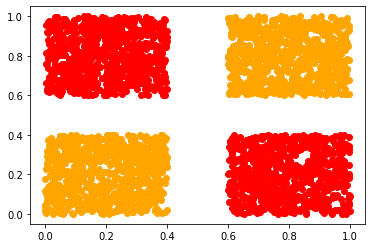

In [406]:
#Generating the dataset 
batch_size = 32 
n_batch = 100 
dataXor = torch.zeros(batch_size*n_batch,3)
labelXor = torch.zeros(batch_size*n_batch,dtype=int)
for idx in range(batch_size*n_batch):
    digits = torch.rand(2)
    while torch.abs(digits-0.5).min()<0.1:
        digits = torch.rand(2)
    dataXor[idx][:2] = digits
    dataXor[idx][2] = digits[0]*digits[1]
    
    labelXor[idx] = int((torch.round(dataXor[idx][:2]).sum()%2).item())
    
plt.scatter(dataXor[labelXor==1][:,0],dataXor[labelXor==1][:,1],color='red',label='1')
plt.scatter(dataXor[labelXor==0][:,0],dataXor[labelXor==0][:,1],color='orange',label='0')
plt.show()

In [408]:
# Training the model 
archXor = [3,10,10,10,2]
mxor = nn.Sequential(nn.Flatten(), FFNet(archXor,bias=False )).to(DEVICE)
mxor,L1,Entropy= train_record_new_model(mxor,dataXor,labelXor,'XOR',epochs=6,epochs_adv=[])

weights_xor = [A.detach().to('cpu') for A in mxor.parameters()]

Number of batch per epoch :  70


100%|███████████████████████████████████████████| 70/70 [00:14<00:00,  4.98it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  48.92857142857142  %
Test Accuracy :  48.4375  %


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.08it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  50.44642857142857  %
Test Accuracy :  53.02083333333333  %


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.37it/s]


---------------  Epoch :  2  ---------------
Train Accuracy :  67.36607142857143  %
Test Accuracy :  70.41666666666667  %


100%|███████████████████████████████████████████| 70/70 [00:13<00:00,  5.31it/s]


---------------  Epoch :  3  ---------------
Train Accuracy :  73.52678571428571  %
Test Accuracy :  72.60416666666667  %


100%|███████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


---------------  Epoch :  4  ---------------
Train Accuracy :  69.46428571428571  %
Test Accuracy :  68.02083333333333  %


100%|███████████████████████████████████████████| 70/70 [00:11<00:00,  5.90it/s]

---------------  Epoch :  5  ---------------
Train Accuracy :  65.40178571428571  %
Test Accuracy :  69.0625  %


In [402]:
#Attacking 
from foolbox.attacks import L2CarliniWagnerAttack


u,s,v = torch.svd(weights_xor[0])
fmodel = PyTorchModel(mxor, bounds=(0, 1), preprocessing=None)

atkFGM = L2FastGradientAttack()
atk = L2CarliniWagnerAttack()
epsilons=[0.1]
    
data = dataXor
target = labelXor
_,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
dataXor_att=clipped_atk[0]
print(v[:,0])
print(v[:,1])


tensor([ 0.6091, -0.7931])
tensor([0.7931, 0.6091])


In [403]:
# Testing 

print('Accuracy normale :', test(mxor,dataXor,labelXor))
print('Accuracy Attack  : ', test(mxor,dataXor_att.to('cpu'),labelXor))


Accuracy normale : 84.09375
Accuracy Attack  :  64.75


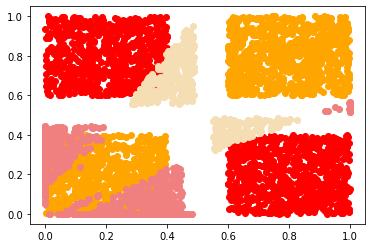

In [404]:
# Plotting attacks 
plt.scatter(dataXor[labelXor==1][:,0],dataXor[labelXor==1][:,1],color='red',label='1')
plt.scatter(dataXor[labelXor==0][:,0],dataXor[labelXor==0][:,1],color='orange',label='0')

dataXor_att = dataXor_att.to('cpu') 
succs = torch.logical_not(succesful_preds(mxor,dataXor_att,labelXor))
X0to1 = dataXor_att[succs*(labelXor==0)]
X1to0 = dataXor_att[succs*(labelXor==1)]
plt.scatter(X0to1[:,0],X0to1[:,1],label='0->1',color='lightcoral')
plt.scatter(X1to0[:,0],X1to0[:,1],label='1->0',color='wheat')

In [401]:
idx = 10
print(dataXor[idx])
print(dataXor_att[idx])

tensor([0.2888, 0.6736])
tensor([1.0000, 0.2336])


# Expé Nicolas : 10 features are enough 

In [410]:
# Loading the data 
activ = torch.load('/home/meller/Documents/giotto-deep/examples/saves/activ_v5')
model = torch.load('/home/meller/Documents/giotto-deep/examples/saves/model_v5')
activG =torch.load('/home/meller/Documents/giotto-deep/examples/saves/activG_v5')

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)


#cpu = torch.ones(1).device


arch = [28*28,100,50,50,50, 10]
optimizer = torch.optim.SGD
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())


predLabel = torch.zeros(activ.shape[0],activ.shape[1])
for alter in range(activ.shape[0]):
    predLabel[alter] = activ[alter,:,-10:].argmax(dim=1)
    
    
label = torch.zeros(activ[0].shape[0])
k_batch = 0 
for data, target in tqdm(dl_tr):
    label[k_batch*32:(k_batch+1)*32]=target
    k_batch+=1
    if k_batch*32>=activ[0].shape[0]:
        break 

 43%|████████████████▌                      | 799/1875 [00:02<00:03, 356.37it/s]


In [518]:
#from gdeep.data import DataLoaderFromArray -> Useless 


from foolbox import PyTorchModel
from foolbox.attacks import L2FastGradientAttack
atkFGM = L2FastGradientAttack()
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
from gdeep.topactivation.svr import SVR

import os 

def train_record_new_model(model,X,y,folder,epochs=5,epochs_adv=[],record=False):
        
    Ntest = 32*30
    perm = torch.randperm(len(X))
    batch_size=128


    X_train = X[perm[Ntest:]]
    y_train = y[perm[Ntest:]].type(torch.LongTensor)
    X_val = X[perm[:Ntest]]
    y_val = y[perm[:Ntest]].type(torch.LongTensor)


    #model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False )).to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
    #optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    
    atkFGM = L2FastGradientAttack()
    epsilons=[2.0]
    
    if record:
        if not os.path.exists('record/'+folder):
            os.mkdir('record/'+folder)
        
        
    n_batch = len(X_train)//batch_size
    print("Number of batch per epoch : ",n_batch)
    
    L1 = torch.zeros((n_batch*epochs,len(arch)-2))
    Entropy = torch.zeros((n_batch*epochs,len(arch)-2))
    PM = torch.zeros((n_batch*epochs))

    
    for epoch in range(epochs):
        correct_pred = 0
        total_pred = 0
        model.train()
        for batch_idx in tqdm(range(n_batch)):
            if X_train.shape[1]==784:
                data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            else: 
                data = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
                
            target = y_train[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            
         
            weights = [A.detach() for A in list(model.parameters())]
            name = 'record/'+folder+'/'+str(epoch)+'_'+str(batch_idx)

            svr = SVR(weights)
            if record:
                if epoch in epochs_adv:
                    svr.plot_save(name,nodeColor='red')
                else:
                    svr.plot_save(name,nodeColor='blue')
            L1[epoch*n_batch+batch_idx]= svr.L1()
            Entropy[epoch*n_batch+batch_idx]= svr.entropy()
            PM[epoch*n_batch+batch_idx] = svr.pathmetric(svdThreshold=1)

            
            
            if epoch in epochs_adv:
                fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=None)
                _,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), target.to(DEVICE),epsilons=epsilons)
                data=clipped_atk[0]

            
            
         
            
            optimizer.zero_grad()
            output = model(data)
            
            loss = loss_fn(output, target)
            
            loss.backward()
            optimizer.step()

            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]
        print(15*'-'+' ', 'Epoch : ', epoch, ' ' + 15*'-')
        print('Train Accuracy : ',correct_pred/total_pred*100, ' %')
        model.eval()
        correct_pred = 0
        total_pred = 0
        for batch_idx in range(len(X_val)//batch_size):
            if X_val.shape[1]==784:
                data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].reshape(batch_size,1,28,28).to(DEVICE)
            else: 
                data = X_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)
            target = y_val[batch_idx*batch_size:(batch_idx+1)*batch_size].to(DEVICE)

            output = model(data)


            correct_pred+=(output.argmax(dim=1)==target).sum().item()
            total_pred += data.shape[0]

        print('Test Accuracy : ',correct_pred/total_pred*100, ' %') 
    return model,L1,Entropy,PM

In [535]:
n_features = 20
_,_,v  = torch.svd(weights[0]) #model driven compression 
#v,_,_ = torch.svd(activ[0][:,:784].T)#data driven compression 



print(v.shape)
v = v.to('cpu')
data = activ[0][:,:784]@v[:,:n_features]

arch = [n_features,100,50,50,50, 10]
optimizer = torch.optim.SGD
model =FFNet(arch,bias=False )




torch.Size([784, 100])


In [527]:
model, _,_,_ = train_record_new_model(model.to(DEVICE),data,label,'none',epochs=3)

Number of batch per epoch :  192


100%|█████████████████████████████████████████| 192/192 [00:04<00:00, 48.00it/s]


---------------  Epoch :  0  ---------------
Train Accuracy :  38.4521484375  %
Test Accuracy :  73.4375  %


100%|█████████████████████████████████████████| 192/192 [00:03<00:00, 49.27it/s]


---------------  Epoch :  1  ---------------
Train Accuracy :  82.76774088541666  %
Test Accuracy :  85.71428571428571  %


100%|█████████████████████████████████████████| 192/192 [00:03<00:00, 50.94it/s]

---------------  Epoch :  2  ---------------
Train Accuracy :  89.4775390625  %
Test Accuracy :  89.50892857142857  %


In [537]:
def test(model,X,y):
    output = model(X.to(DEVICE))
    pred=output.argmax(dim=1).to('cpu')
    return ((pred==y).sum()/X.shape[0]*100).item()

epsilons = [2]
fmodel = PyTorchModel(model.to(DEVICE), bounds=(-200, 200), preprocessing=None)
_,clipped_atk,_ = atkFGM(fmodel, data.to(DEVICE), label.type(torch.LongTensor).to(DEVICE),epsilons=epsilons)
data_atk=clipped_atk[0].to('cpu')


/home/linuxbrew/.linuxbrew/opt/python@3.9/lib/python3.9/site-packages/foolbox/models/pytorch.py:36: UserWarning:

The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.



In [529]:
print('Accuracy normale :', test(model,data,label))
print('Accuracy attack :', test(model,data_atk,label))

(data_atk-data)[10].norm()

Accuracy normale : 90.03515625
Accuracy attack : 22.99609375


tensor(2.)

(array([ 174., 1639., 4833., 7026., 5911., 3483., 1727.,  635.,  149.,
          23.]),
 array([1.817532 , 2.6155388, 3.4135458, 4.211553 , 5.0095596, 5.8075666,
        6.6055737, 7.4035807, 8.201588 , 8.999595 , 9.797602 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

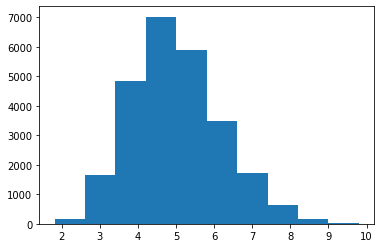

In [539]:
plt.hist(data.norm(dim=1).numpy())

(array([  48.,  671., 2786., 5830., 7136., 5517., 2704.,  763.,  131.,
          14.]),
 array([ 3.5698273,  4.834766 ,  6.0997043,  7.3646426,  8.629581 ,
         9.89452  , 11.159458 , 12.4243965, 13.689335 , 14.954273 ,
        16.219212 ], dtype=float32),
 <BarContainer object of 10 artists>)

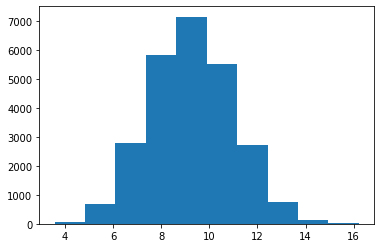

In [540]:
plt.hist(activ[0][:,:784].norm(dim=1).numpy())

tensor(5, device='cuda:0')


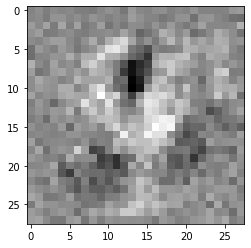

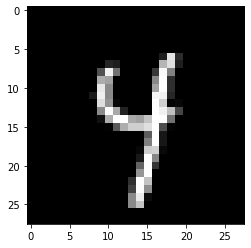

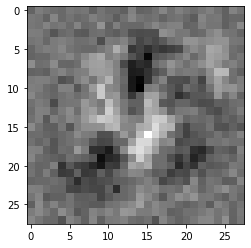

In [538]:
# Reconstruction visu : 


idx = 26
print(model(data_atk[idx].to(DEVICE)).argmax())
reco = v[:,:n_features]@ data[idx] 
print28x28tensor(reco)
plt.show()
print28x28tensor(activ[0][idx,:784])
plt.show()
reco = v[:,:n_features]@ data_atk[idx] 

print28x28tensor(reco)